# 2dcubes Intervention Encoder

Exploring intervention encoder output and why noise/causal variables are not being disentangled.

## Setup

In [1]:
#from experiments.cubes_2d_complete import get_dataloader, create_model, eval_dci_scores
from experiments.cubes_2d import get_dataloader, create_model, eval_dci_scores

/mnt/antares_raid/home/jonasb/mambaforge/envs/wscrl/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/antares_raid/home/jonasb/Projects/wscrl/repo/experiments/cubes_2d.py:50: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(


In [2]:
import logging
from omegaconf import OmegaConf
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Subset

torch.set_grad_enabled(False)

logger = logging.getLogger()

# EXP_DIR = Path("/mnt/raid/ni/jonasb/wscrl/saved/sbd_complete")
# EXP_DIR = Path("/mnt/raid/ni/jonasb/wscrl/saved/causal_variables_wrong_top?")
# EXP_DIR = Path("/mnt/raid/ni/jonasb/wscrl/sbd_on_encodings")
EXP_DIR = Path("/mnt/raid/ni/jonasb/wscrl/cubes_2d_on_encoded_allow_collisions_equi_child_noise")

model_path = EXP_DIR / "models" / "model.pt"
# model_path = EXP_DIR / "models" / "model_step_150000.pt"
cfg_path = EXP_DIR / "config.yml"

cfg = OmegaConf.load(cfg_path)

model = create_model(cfg)
model.load_state_dict(torch.load(model_path))
model.eval()

device = torch.device(cfg.training.device)
model.to(device)

CAUSAL_VARIABLES = [
    "pos_x1",
    "pos_y1",
    "pos_x2",
    "pos_y2",
    "pos_x3",
    "pos_y3",
]

CAUSAL_GRAPH = torch.tensor(
    [
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
    ]
)

In [3]:
root_variables_indices = []
children_variables_indices = []
for i in range(len(CAUSAL_VARIABLES)):
    if (CAUSAL_GRAPH[:, i] == 0).all():
        root_variables_indices.append(i)
    else:
        children_variables_indices.append(i)
print(f"{root_variables_indices=}, {children_variables_indices=}")

root_variables_indices=[0, 1, 2, 3], children_variables_indices=[4, 5]


In [4]:
train_loader = get_dataloader(
    cfg, "train", batchsize=cfg.training.batchsize, shuffle=False, include_noise_encodings=True
)
val_loader = get_dataloader(
    cfg, "val", batchsize=cfg.training.batchsize, shuffle=False, include_noise_encodings=True
)

In [5]:
dim_z = cfg.model.dim_z
num_interventions = dim_z + 1  # dim_z + empty intervention

## Intervention Posteriors

### Average intervention posterior per intervention label

Looking at intervention posteriors for different inputs.

In [6]:
from notebooks.util import (
    calculate_intervention_posteriors,
    calculate_intervention_posterior_heatmap,
    plot_intervention_posterior_heatmap,
)

In [7]:
def scatter_plot_variable_pairs(data, variable_names, title=None):
    fig, ax = plt.subplots(
        nrows=data.shape[1],
        ncols=data.shape[1],
        figsize=(data.shape[1] * 1.5, data.shape[1] * 1.5),
        # dpi=70,
        sharex=True,
        sharey=True,
    )

    for i in range(data.shape[1]):
        # turn of axes for lower triangle
        for j in range(i):
            ax[i, j].axis("off")
        for j in range(i, data.shape[1]):
            ax[i, j].scatter(
                data[:, i].cpu().detach().numpy(),
                data[:, j].cpu().detach().numpy(),
                s=0.5,
            )
            ax[i, j].set_xlabel(variable_names[i])
            ax[i, j].set_ylabel(variable_names[j])

    fig.suptitle(title or "Scatter plot of variables")
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

In [8]:
def scatter_plot_intervention_posterior_pairs(
    intervention_posteriors,
    intervention_labels=None,
    intervention_label_subset=None,
    variable_subset=None,
):
    if variable_subset is not None:
        intervention_posteriors = intervention_posteriors[:, variable_subset]
    if intervention_label_subset is not None:
        assert intervention_labels is not None
        indices = sum(intervention_labels == i for i in intervention_label_subset).bool().squeeze()
        intervention_posteriors = intervention_posteriors[indices]

    if variable_subset is None:
        variable_names = ["empty"] + [f"e{i}" for i in range(1, intervention_posteriors.shape[1])]
    else:
        variable_names = [f"e{variable_subset[i]}" for i in range(len(variable_subset))]
        if 0 in variable_subset:
            variable_names[variable_subset.index(0)] = "empty"
    title = f"Scatter plot of intervention posterior pairs"
    if intervention_label_subset is not None:
        title += f" for interventions {intervention_label_subset}"
    scatter_plot_variable_pairs(intervention_posteriors, variable_names, title=title)

In [9]:
def plot_posterior_bar_chart(heatmap, colors, dim_z):
    fig, axes = plt.subplots(nrows=num_interventions, ncols=1, figsize=(5, 1.5 * num_interventions))
    for i in range(num_interventions):
        ax = axes[i]
        ax.bar(range(num_interventions), heatmap[i].cpu().detach().numpy(), color=colors)
        ax.set_xticks(range(num_interventions))
        ax.set_xticklabels(["empty"] + [f"$\widehat{{z_{i + 1}}}$" for i in range(dim_z)])
        ax.set_ylabel("Posterior")
        ax.set_xlabel("Intervention on")
        if i == 0:
            ax.set_title("Empty intervention")
        else:
            ax.set_title(f"Intervention on $z_{i}$")

    fig.suptitle("Intervention encoder posterior for each intervention label")

    plt.tight_layout()
    plt.show()

In [10]:
intervention_posteriors_train, intervention_labels_train = calculate_intervention_posteriors(
    model, train_loader, device=device
)
intervention_posteriors_val, intervention_labels_val = calculate_intervention_posteriors(
    model, val_loader, device=device
)

Batch 391 / 391
Batch 391 / 391


The plot shows the intervention posterior heatmap for each true and predicted intervention. 

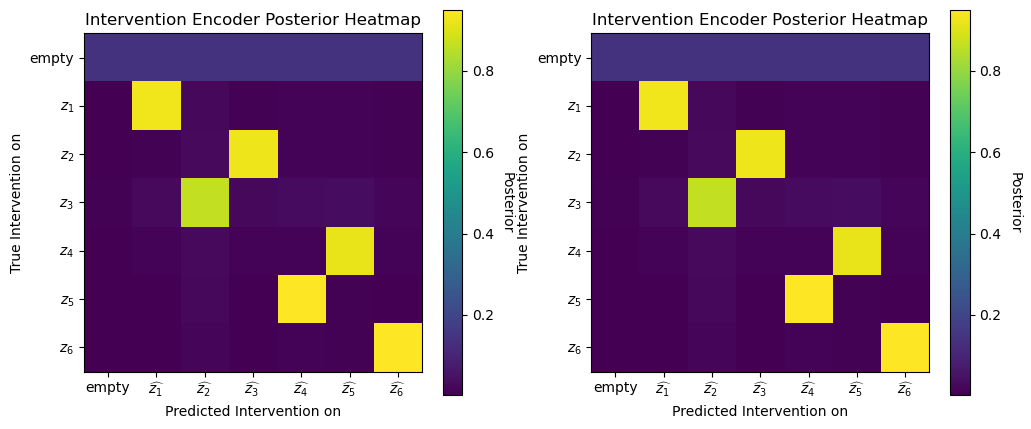

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

heatmap_train = calculate_intervention_posterior_heatmap(
    intervention_posteriors_train, intervention_labels_train, dim_z, device=device
)
plot_intervention_posterior_heatmap(heatmap_train, dim_z, ax=axes[0])

heatmap_val = calculate_intervention_posterior_heatmap(
    intervention_posteriors_val, intervention_labels_val, dim_z, device=device
)
plot_intervention_posterior_heatmap(heatmap_val, dim_z, ax=axes[1])

<mark>NOTE: Problems for intervention encoder only come up on training but not validation data. Why?</mark>

Try different stages of the model to see if errors intervention encoding stem from overfitting.

In [12]:
model_paths = EXP_DIR / "models"


def plot_intervention_posterior_heatmap_for_model_checkpoints(
    model_paths, train_loader, val_loader, every_nth=10, last_n=0
):
    sorted_model_paths = sorted(
        model_paths.glob("model_step_*.pt"), key=lambda x: int(x.stem.split("_")[-1])
    )

    sorted_model_paths = (sorted_model_paths[::every_nth] if every_nth > 0 else []) + (
        sorted_model_paths[-last_n:] if last_n > 0 else []
    )
    for model_checkpoint_path in sorted_model_paths:
        print(f"Plotting {model_checkpoint_path}")
        model.load_state_dict(torch.load(model_checkpoint_path))
        model.eval()
        (
            intervention_posteriors_train,
            intervention_labels_train,
        ) = calculate_intervention_posteriors(model, train_loader, device=device)
        intervention_posteriors_val, intervention_labels_val = calculate_intervention_posteriors(
            model, val_loader, device=device
        )

        fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

        heatmap_train = calculate_intervention_posterior_heatmap(
            intervention_posteriors_train, intervention_labels_train, dim_z, device=device
        )
        plot_intervention_posterior_heatmap(heatmap_train, dim_z, ax=axes[0])

        heatmap_val = calculate_intervention_posterior_heatmap(
            intervention_posteriors_val, intervention_labels_val, dim_z, device=device
        )
        plot_intervention_posterior_heatmap(heatmap_val, dim_z, ax=axes[1])
        plt.show()

In [13]:
# plot_intervention_posterior_heatmap_for_model_checkpoints(
#     model_paths, train_loader, val_loader, every_nth=3
# )

In [14]:
# plot_intervention_posterior_heatmap_for_model_checkpoints(
#     model_paths, train_loader, val_loader, every_nth=0, last_n=5
# )

Interventions on the sphere (child object) $z_5$ and $z_6$ correspond to $\widehat{z_4}$ and $\widehat{z_6}$, respectively.

We can see that interventions on $z_3$ and $z_4$ (pos_x2 and pos_y2), which are interventions on the cone (parent), are frequently confused with interventions on the sphere (child).

In [15]:
# Maximal a posteriori intervention for each intervention label
_, MAP_interventions = heatmap_val.max(dim=1)
print(f"{MAP_interventions=}")

MAP_interventions=tensor([0, 1, 3, 2, 5, 4, 6], device='cuda:1')


In [16]:
# hightlight MAP intervention of children variables, i.e. latent dimension that corresponds to true child intervention
colors = [
    "blue" if MAP_interventions[i - 1] not in children_variables_indices else "red"
    for i in range(num_interventions)
]

The plot shows the average posterior of the intervention encoder (predicted intervention) for each intervention label. For the heuristic intervention encoder this corresponds to the change of the components in the noise encodings.

Same plot but with bar chart instead:

For tag train:


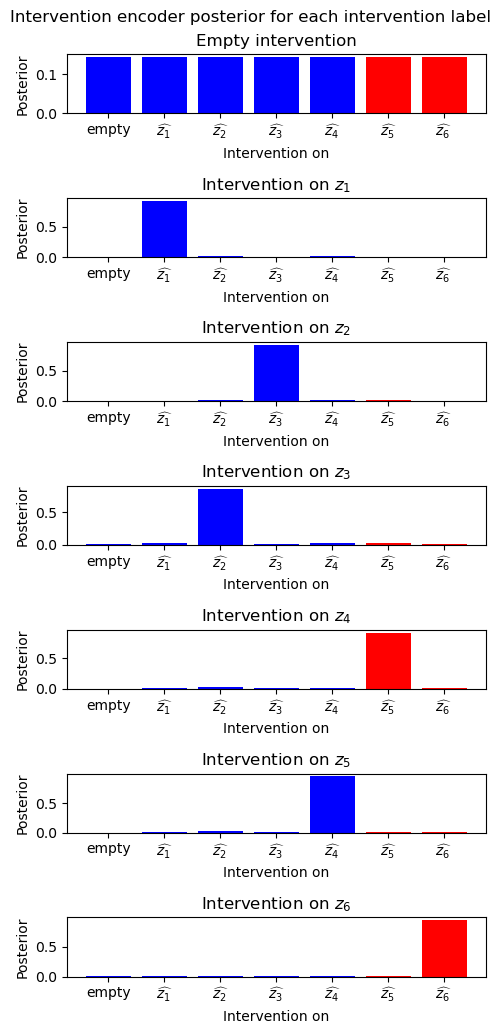

For tag val:


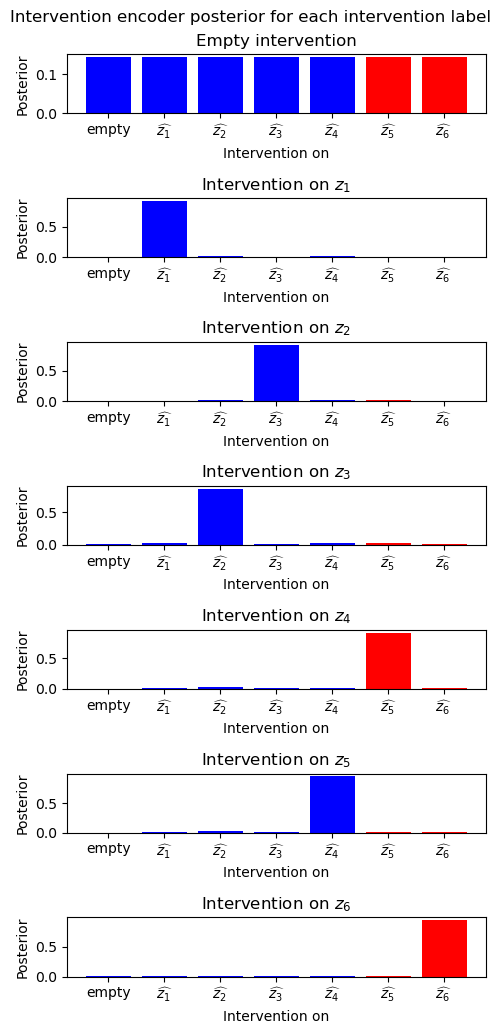

In [17]:
for tag, heatmap in zip(["train", "val"], [heatmap_train, heatmap_val]):
    print(f"For tag {tag}:")
    plot_posterior_bar_chart(heatmap, colors, dim_z)

### Pairs of intervention labels

Only looked at average posterior so far. Now looking at pairs of variables to see if encoder 
1. gives high certainty sometimes to wrong and sometimes to right intervention
2. or if it is uncertain between the right and wrong intervention.

In [18]:
tag = "train"  # "val"
if tag == "train":
    intervention_posteriors, intervention_labels = (
        intervention_posteriors_train,
        intervention_labels_train,
    )
    dataloader = train_loader
elif tag == "val":
    intervention_posteriors, intervention_labels = (
        intervention_posteriors_val,
        intervention_labels_val,
    )
    dataloader = val_loader
else:
    raise ValueError(f"Unknown tag {tag=}")

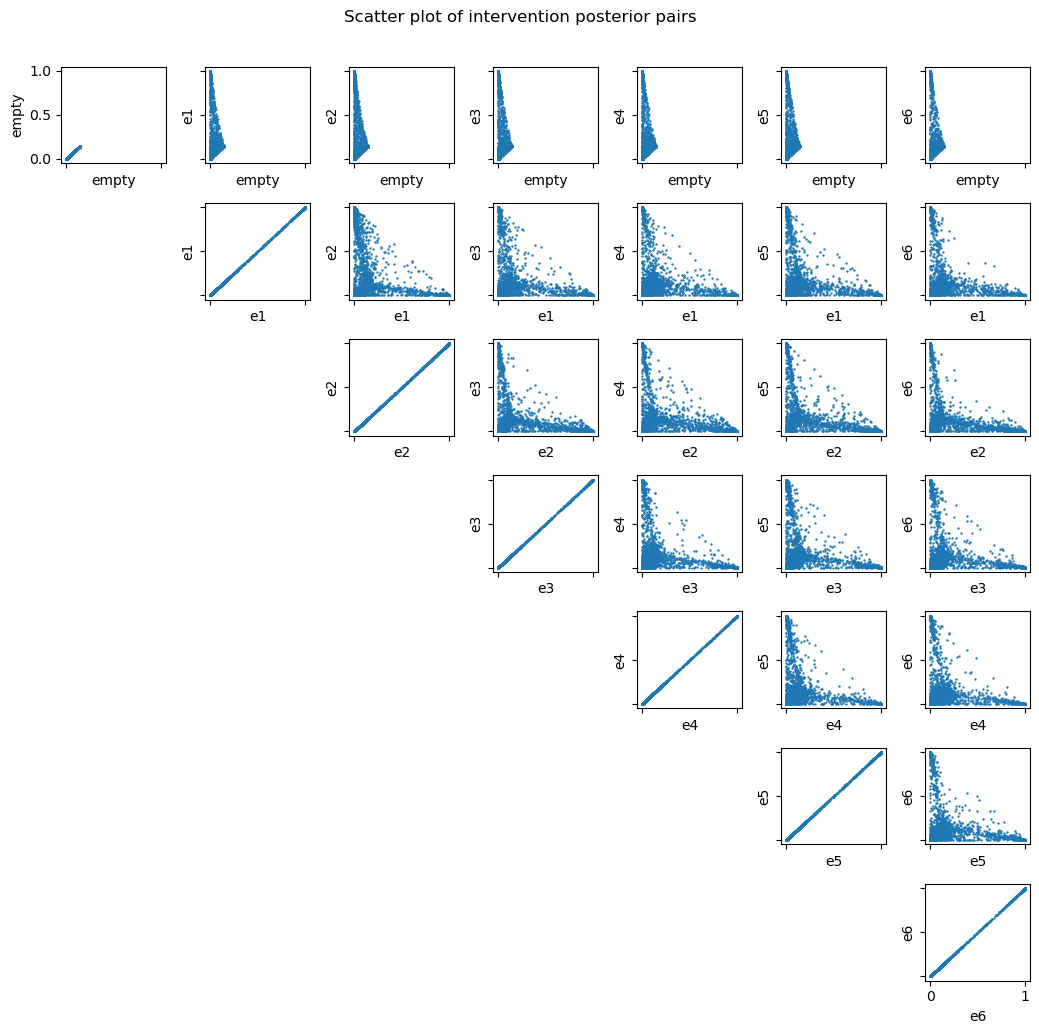

In [19]:
# all interventions, all variables
scatter_plot_intervention_posterior_pairs(intervention_posteriors)

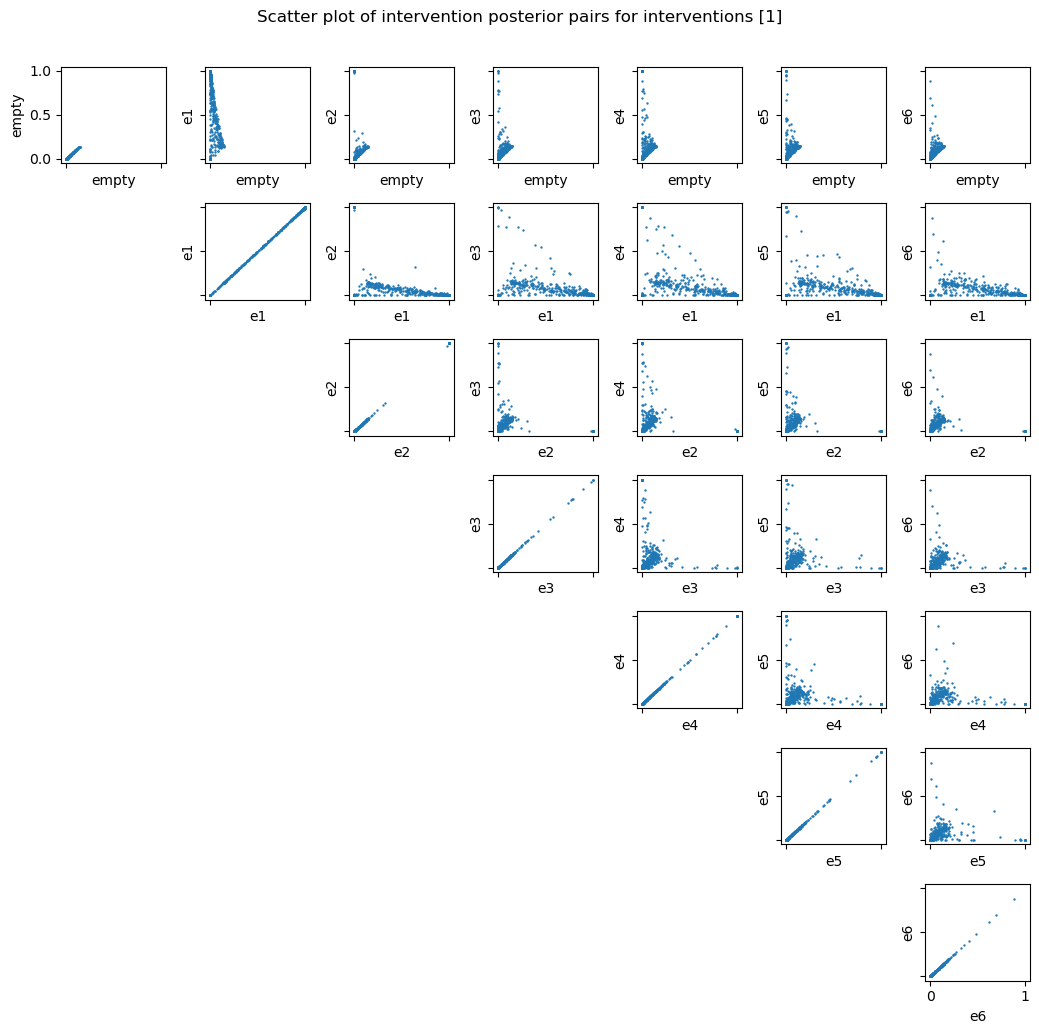

In [20]:
scatter_plot_intervention_posterior_pairs(
    intervention_posteriors, intervention_labels, intervention_label_subset=[1]
)

For "unproblematic" intervention on $z_1$, we can see that never gives high certainty to two interventions at the same time.

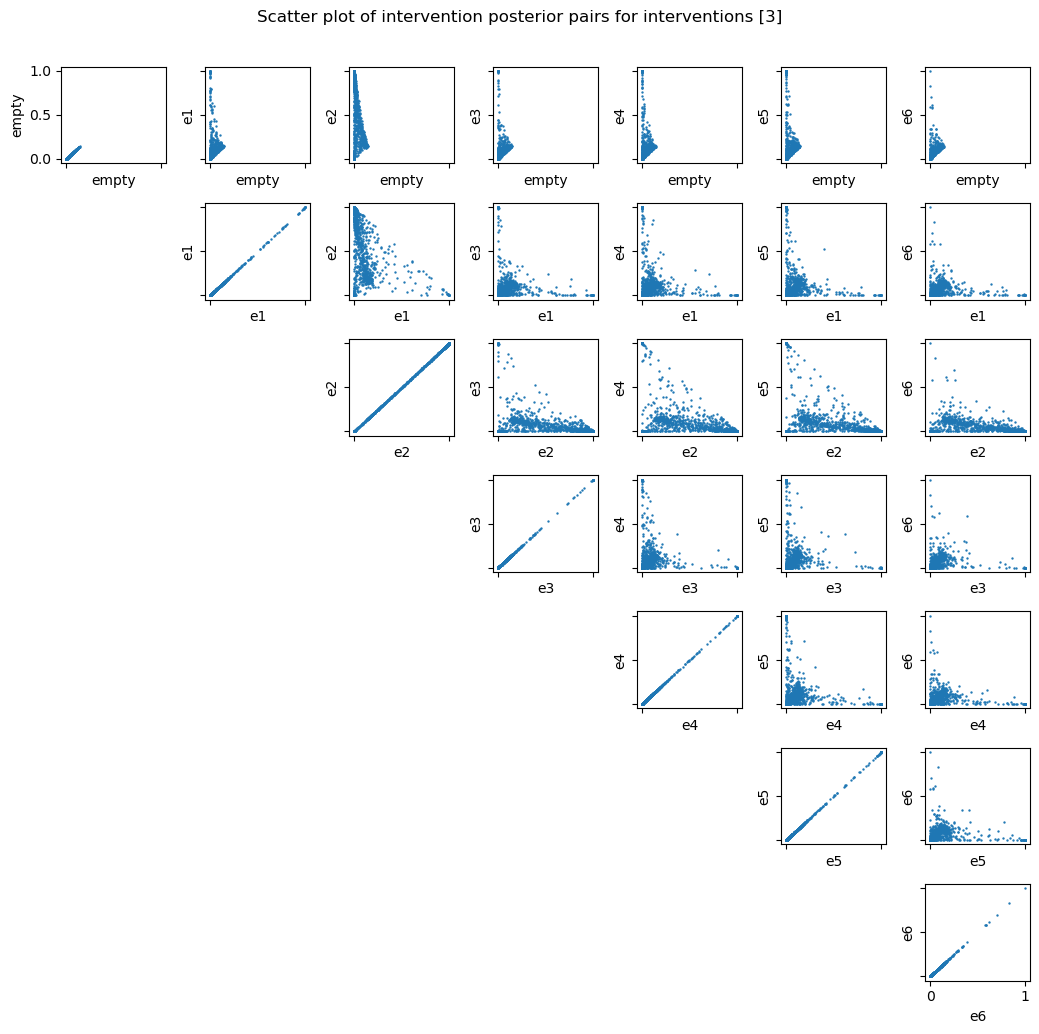

In [21]:
scatter_plot_intervention_posterior_pairs(
    intervention_posteriors, intervention_labels, intervention_label_subset=[3]
)

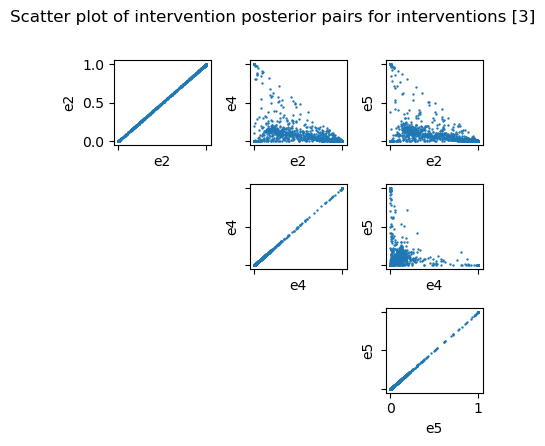

In [22]:
scatter_plot_intervention_posterior_pairs(
    intervention_posteriors,
    intervention_labels,
    intervention_label_subset=[3],
    variable_subset=[2, 4, 5],
)

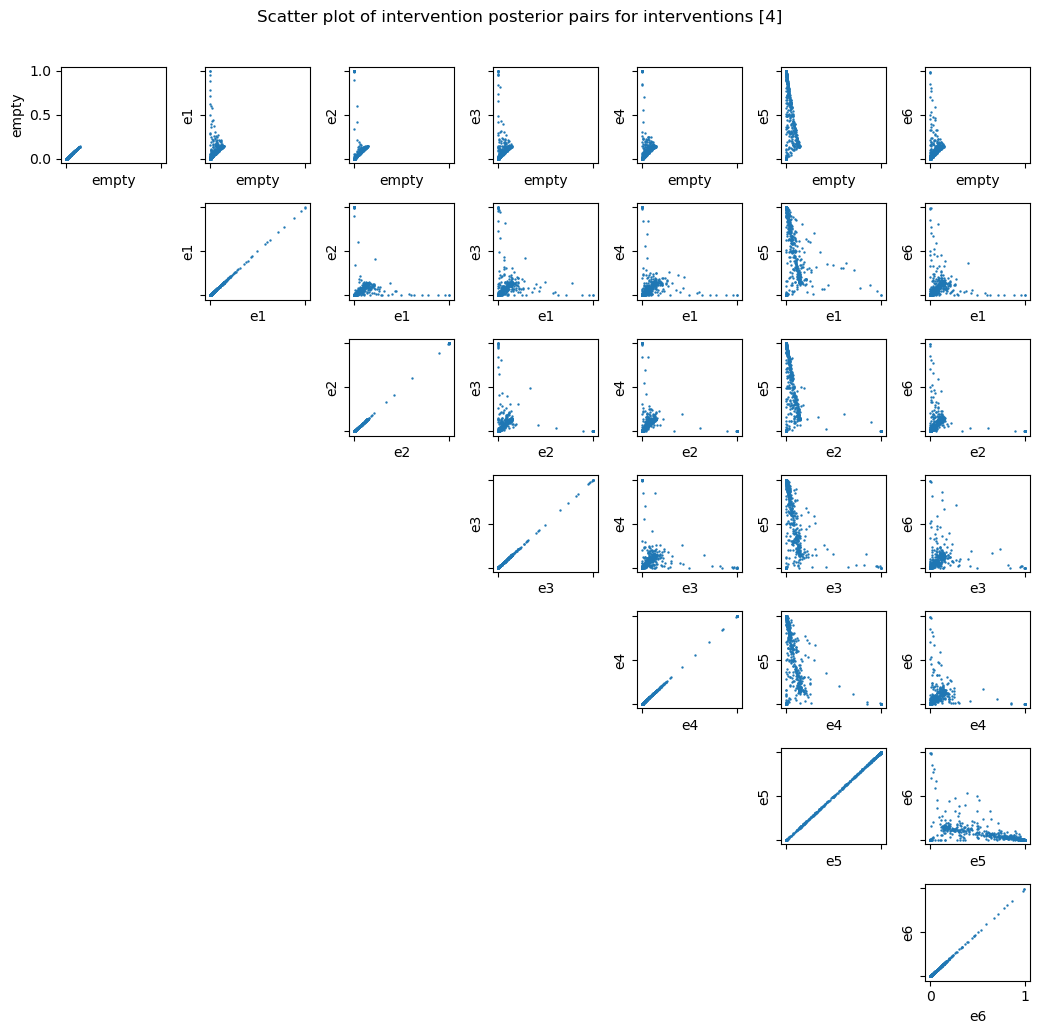

In [23]:
scatter_plot_intervention_posterior_pairs(
    intervention_posteriors, intervention_labels, intervention_label_subset=[4]
)

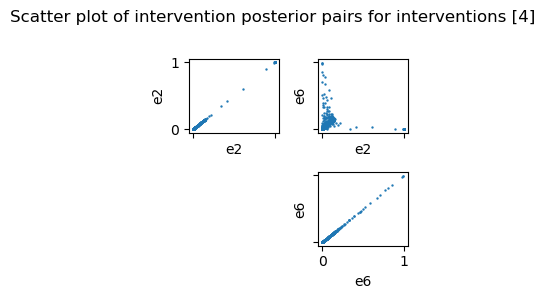

In [24]:
scatter_plot_intervention_posterior_pairs(
    intervention_posteriors,
    intervention_labels,
    intervention_label_subset=[4],
    variable_subset=[2, 6],
)

For interventions on $z_3$ and $z_4$, we can see that there are pairs of interventions where the encoder gives high certainty to both and cannot reliably differentiate between the two.
From looking at the heatmap, we can see that the other variable is one that corresponds to the child object.

## Identify worst examples

In [25]:
tag = "train"  # "val"
if tag == "train":
    intervention_posteriors, intervention_labels = (
        intervention_posteriors_train,
        intervention_labels_train,
    )
    dataloader = train_loader
elif tag == "val":
    intervention_posteriors, intervention_labels = (
        intervention_posteriors_val,
        intervention_labels_val,
    )
    dataloader = val_loader
else:
    raise ValueError(f"Unknown tag {tag=}")

### By Loss/MSE

In [26]:
def plot_sample_overview(
    x1,
    x1_hat,
    x2,
    x2_hat,
    intervention_labels,
    colors,
    intervention_posteriors=None,
    nrows=None,
    title=None,
):
    ncols = 5
    if intervention_posteriors is not None:
        ncols += 1

    if nrows is None:
        nrows = len(x1)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(1.5 * ncols, nrows))

    for ax in axes.flatten():
        ax.axis("off")

    for i in range(nrows):
        axes[i, 0].imshow(x1[i].permute(1, 2, 0).clamp(0, 255).to(torch.uint8))
        axes[i, 1].imshow(x1_hat[i].permute(1, 2, 0).clamp(0, 255).to(torch.uint8))
        axes[i, 2].imshow(x2[i].permute(1, 2, 0).clamp(0, 255).to(torch.uint8))
        axes[i, 3].imshow(x2_hat[i].permute(1, 2, 0).clamp(0, 255).to(torch.uint8))

        # show intervention label as text
        axes[i, 4].text(
            0.5,
            0.5,
            str(intervention_labels[i].item()),
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=20,
        )
        axes[i, 4].axis("off")

        if intervention_posteriors is not None:
            axes[i, 5].bar(
                range(num_interventions),
                intervention_posteriors[i].cpu().detach().numpy(),
                color=colors,
            )
    # column titles
    axes[0, 0].set_title("x1")
    axes[0, 1].set_title("x1_hat")
    axes[0, 2].set_title("x2")
    axes[0, 3].set_title("x2_hat")
    axes[0, 4].set_title("intervention label")
    if intervention_posteriors is not None:
        axes[0, 5].set_title("intervention posterior")

    if title is not None:
        fig.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

In [27]:
losses = []
mses = []

for i, (x1, x2, z1, z2, intervention_labels, *_) in enumerate(dataloader):
    print(f"Batch {i + 1} / {len(dataloader)}", end="\r")
    # GPU
    x1, x2, z1, z2, intervention_labels = (
        x1.to(device),
        x2.to(device),
        z1.to(device),
        z2.to(device),
        intervention_labels.to(device),
    )
    loss, model_outputs = model(
        x1,
        x2,
    )
    mse = model_outputs["consistency_mse"]
    losses.append(loss.detach().cpu().numpy())
    mses.append(mse.detach().cpu().numpy())
print()


losses = np.concatenate(losses).flatten()
mses = np.concatenate(mses).flatten()

Batch 391 / 391


In [28]:
def get_n_highest_indices(array, n):
    return np.argpartition(array, -n)[-n:]


def get_n_lowest_indices(array, n):
    return np.argpartition(array, n)[:n]

In [29]:
def unnormalize(cfg, x):
    if cfg.preprocessing.normalization.type == "minmax":
        x = x * (
            torch.FloatTensor(cfg.data.x_max).view(3, 1, 1)
            - torch.FloatTensor(cfg.data.x_min).view(3, 1, 1)
        ).to(device) + torch.FloatTensor(cfg.data.x_min).view(3, 1, 1).to(device)
    else:
        raise NotImplementedError
    return x

In [30]:
def plot_first_batch(cfg, dataloader, with_intervention_posteriors=False, title=None):
    x1, x2, z1, z2, intervention_labels, *_ = next(iter(dataloader))
    x1, x2, z1, z2, intervention_labels = (
        x1.to(device),
        x2.to(device),
        z1.to(device),
        z2.to(device),
        intervention_labels.to(device),
    )
    x1_hat = model.encode_decode(x1, deterministic=True)
    x2_hat = model.encode_decode(x2, deterministic=True)

    intervention_posteriors = None
    if with_intervention_posteriors:
        intervention_encoder_inputs = torch.cat(
            (
                model.encoder.mean_std(x1)[0],
                model.encoder.mean_std(x2)[0] - model.encoder.mean_std(x1)[0],
            ),
            dim=1,
        )
        intervention_posteriors = model.intervention_encoder(intervention_encoder_inputs)

    plot_sample_overview(
        unnormalize(cfg, x1).cpu().detach(),
        unnormalize(cfg, x1_hat).cpu().detach(),
        unnormalize(cfg, x2).cpu().detach(),
        unnormalize(cfg, x2_hat).cpu().detach(),
        intervention_labels,
        intervention_posteriors=intervention_posteriors,
        colors=colors,
        title=title,
    )

In [31]:
metric = "mse"  # "loss"

n_worst = 30
if metric == "mse":
    idx_worst = get_n_highest_indices(mses, n_worst)
elif metric == "loss":
    idx_worst = get_n_highest_indices(losses, n_worst)
else:
    raise NotImplementedError
dataset_worst = Subset(dataloader.dataset, idx_worst)
dataloader_worst = DataLoader(dataset_worst, batch_size=dataset_worst.indices.size)

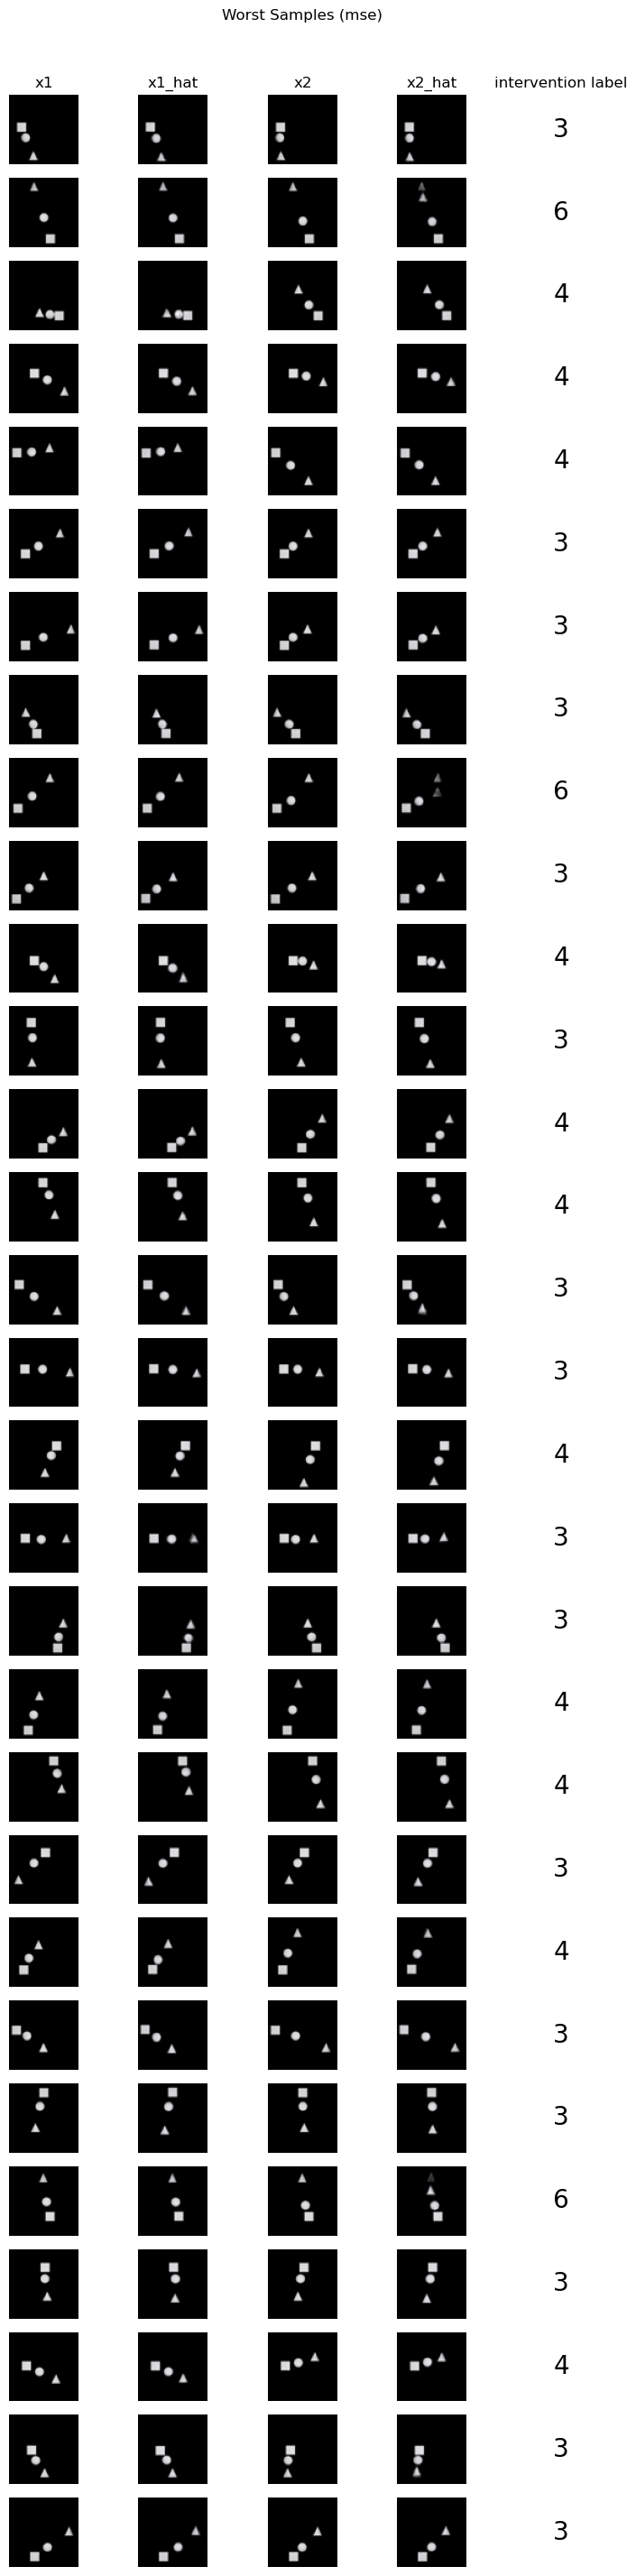

In [92]:
plot_first_batch(cfg, dataloader_worst, title=f"Worst Samples ({metric})")

### By intervention uncertainty

NOTE: For some reason, the intervention encoder issues only exist for training data and not for validation data!

In [93]:
tag = "train"  # "train"
if tag == "train":
    intervention_posteriors, intervention_labels = (
        intervention_posteriors_train,
        intervention_labels_train,
    )
    dataloader = train_loader
elif tag == "val":
    intervention_posteriors, intervention_labels = (
        intervention_posteriors_val,
        intervention_labels_val,
    )
    dataloader = val_loader
else:
    raise NotImplementedError

In [94]:
import scipy.stats as stats

intervention_posterior_entropies = stats.entropy(intervention_posteriors.cpu().T)

In [95]:
# exclude empty intervention
intervention_posterior_entropies_nonempty = intervention_posterior_entropies.copy()
intervention_posterior_entropies_nonempty[(intervention_labels == 0).squeeze().cpu().numpy()] = -1

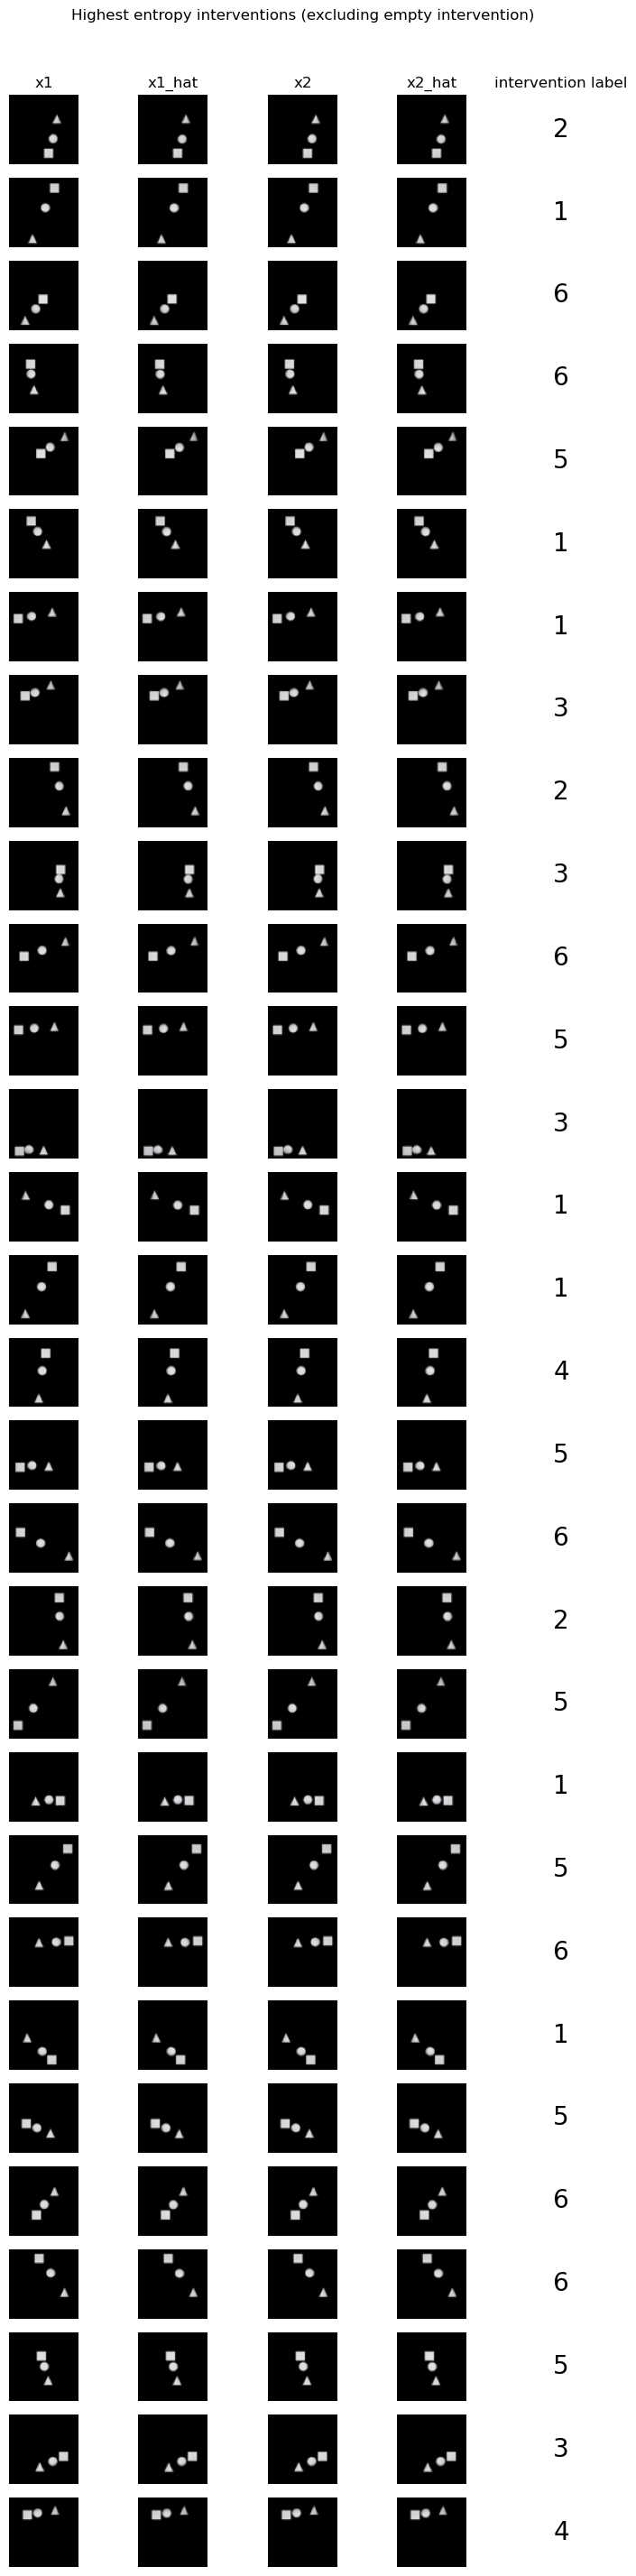

In [96]:
n_worst = 30
idx_worst = get_n_highest_indices(intervention_posterior_entropies_nonempty, n_worst)
dataset_worst = Subset(dataloader.dataset, idx_worst)
dataloader_worst = DataLoader(dataset_worst, batch_size=dataset_worst.indices.size)
plot_first_batch(
    cfg, dataloader_worst, title="Highest entropy interventions (excluding empty intervention)"
)

We can see that, unsurprisingly, the interventions are uncertain, when they are very small and the counterfactual almost looks identical to the original. Not too interesting.

Looking at "problematic" intervention:

In [97]:
label = 4

Random samples for label:

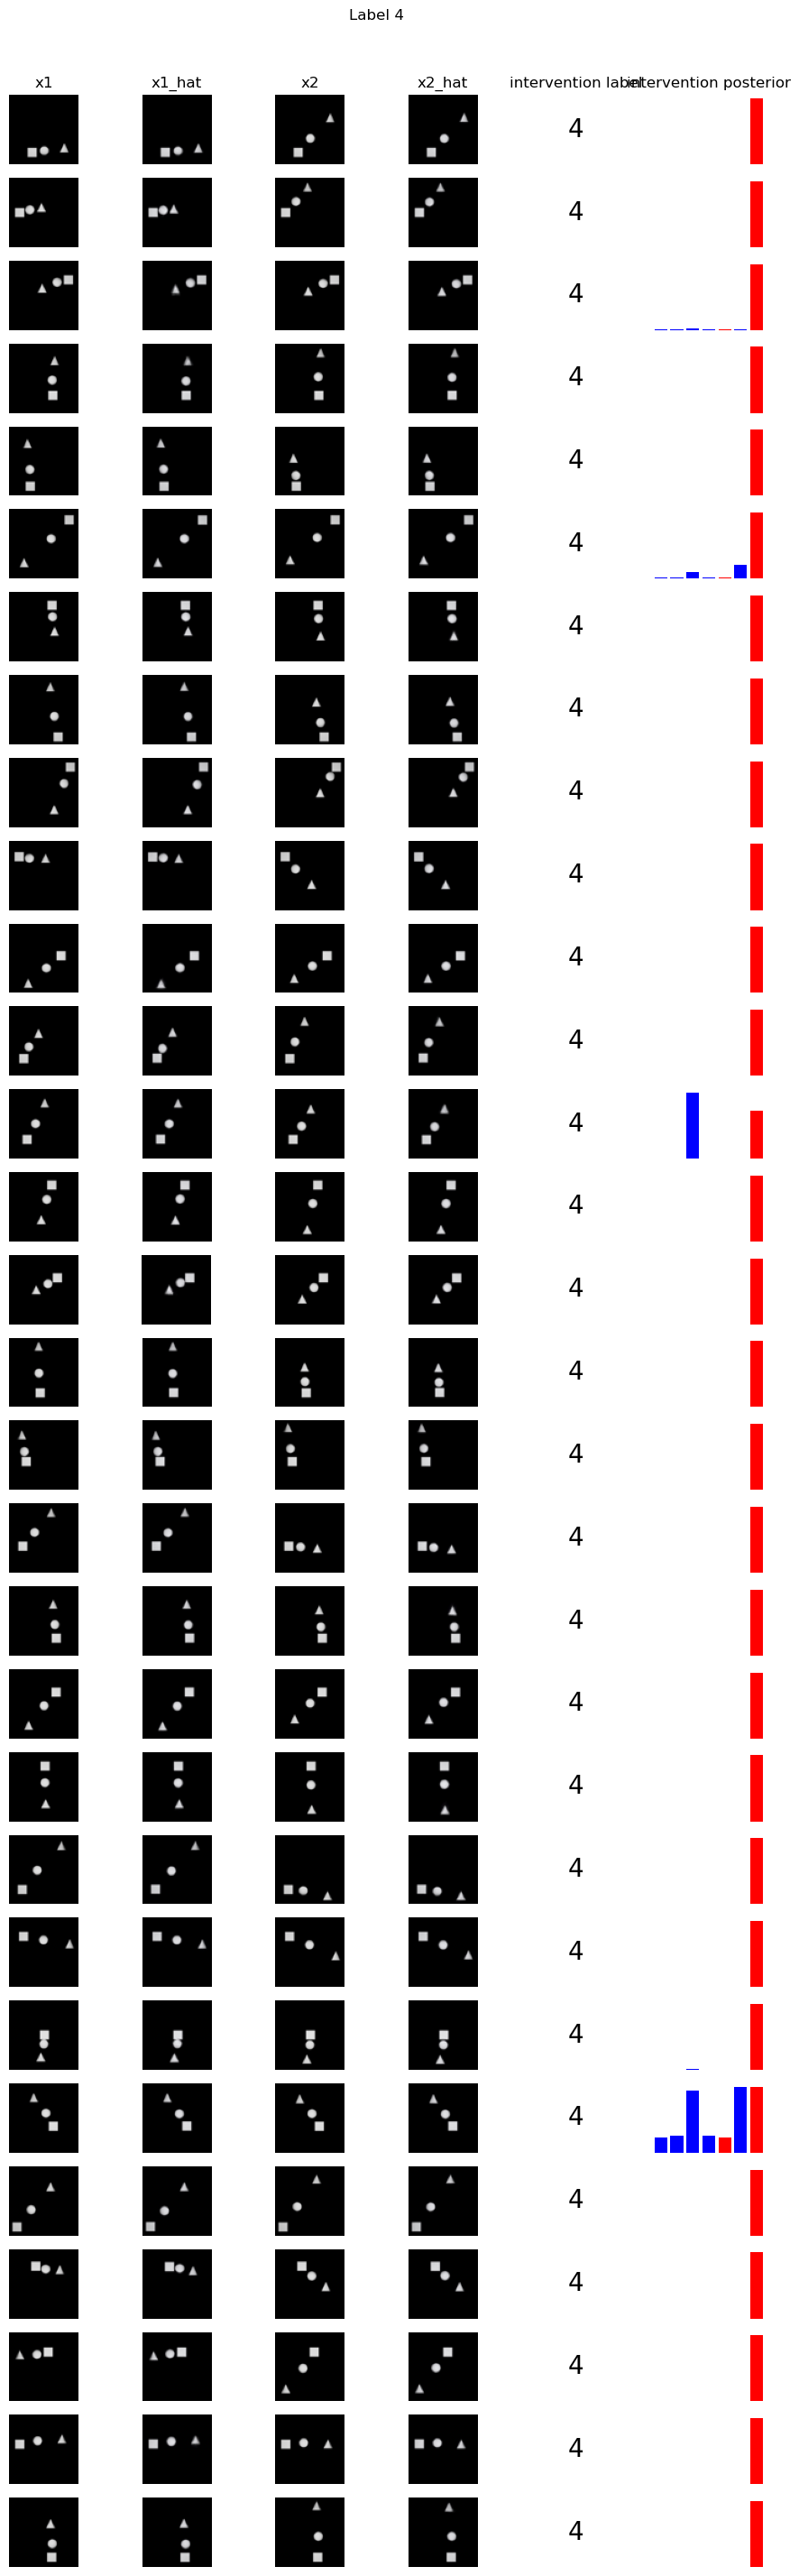

In [98]:
num_samples = 30
indices = np.where(intervention_labels.squeeze().cpu().numpy() == label)[0]
indices = indices[:num_samples]
dataset = Subset(dataloader.dataset, indices)
dataloader = DataLoader(dataset, batch_size=dataset.indices.size)
plot_first_batch(cfg, dataloader, title=f"Label {label}", with_intervention_posteriors=True)

In [99]:
def exclude_non_label_interventions(intervention_posterior_entropies, label):
    intervention_posterior_entropies_label = intervention_posterior_entropies.copy()
    # Set to -1 if intervention label is not label to exclude from high entropy queries
    intervention_posterior_entropies_label[
        (intervention_labels != label).squeeze().cpu().numpy()
    ] = -1
    return intervention_posterior_entropies_label

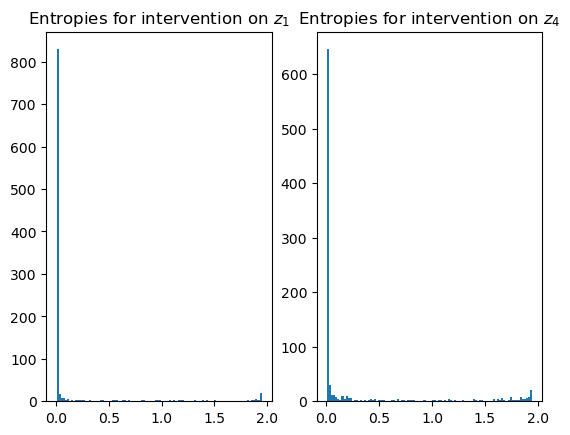

In [100]:
fig, axes = plt.subplots(ncols=2)
for i, label in enumerate([1, 4]):
    ax = axes[i]
    intervention_posterior_entropies_label = exclude_non_label_interventions(
        intervention_posterior_entropies, label
    )
    ax.hist(
        intervention_posterior_entropies_label[intervention_posterior_entropies_label != -1],
        bins=100,
    )
    ax.set_title(f"Entropies for intervention on $z_{label}$")
plt.show()

Can see there are more high entropy samples for "problematic" intervention.

In [101]:
label = 4
intervention_posterior_entropies_label = exclude_non_label_interventions(
    intervention_posterior_entropies, label
)

Looking at samples where entropy between $\widehat{z_2}$ and $\widehat{z_6}$ is high.

In [102]:
variable_subset = [2, 6]
intervention_posterior_entropies_subset = stats.entropy(
    intervention_posteriors[:, variable_subset].cpu().T
)

In [103]:
intervention_posterior_entropies_subset_label = exclude_non_label_interventions(
    intervention_posterior_entropies_subset, label
)

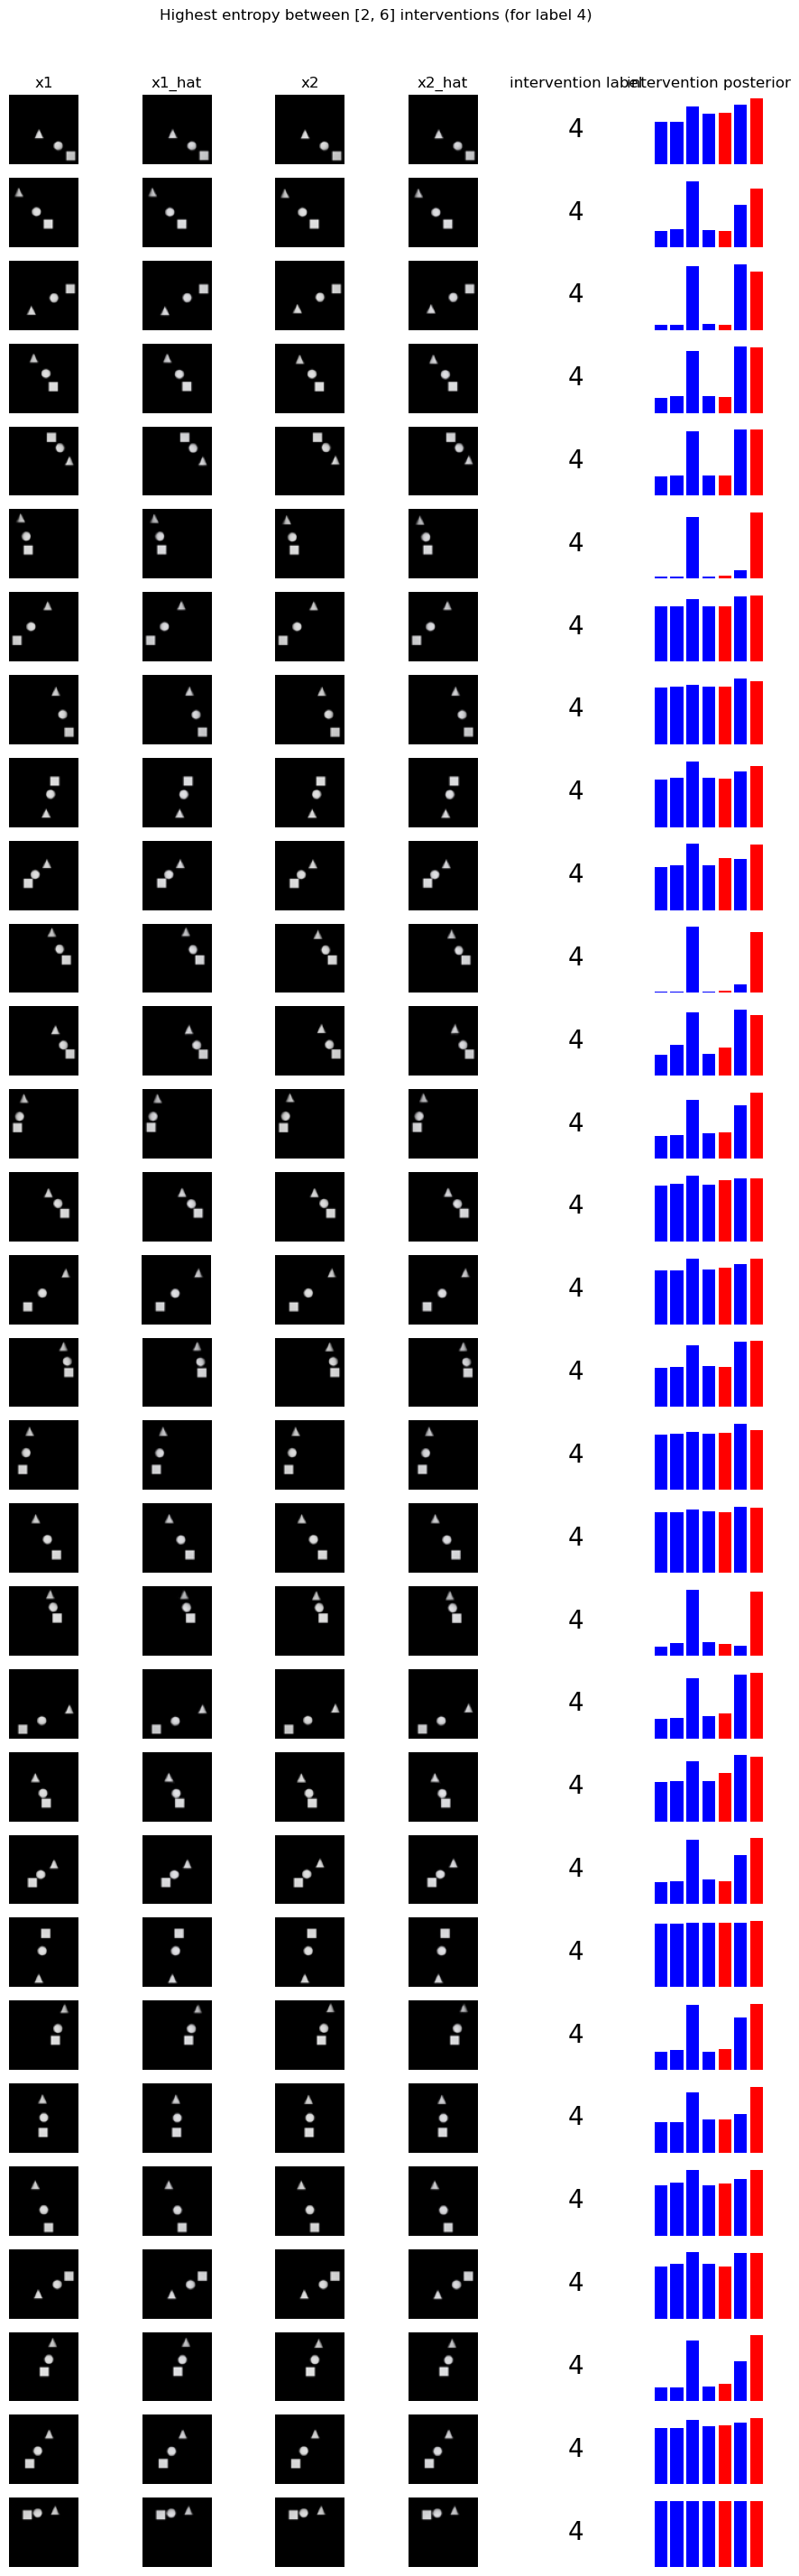

In [104]:
n_worst = 30
idx_worst = get_n_highest_indices(intervention_posterior_entropies_subset_label, n_worst)
dataset_worst = Subset(train_loader.dataset, idx_worst)
dataloader_worst = DataLoader(dataset_worst, batch_size=dataset_worst.indices.size)
plot_first_batch(
    cfg,
    dataloader_worst,
    title=f"Highest entropy between {variable_subset} interventions (for label {label})",
    with_intervention_posteriors=True,
)

## Removing interventions

In [105]:
outputs = eval_dci_scores(cfg, model, test_loader=val_loader)
f"{outputs['noise_disentanglement']=}, {outputs['causal_disentanglement']=}"

"outputs['noise_disentanglement']=0.6171279814378025, outputs['causal_disentanglement']=0.39797340624615246"

In [106]:
def get_filtered_dataloader(cfg, partition, removed_intervention_labels):
    dataloader = get_dataloader(
        cfg,
        partition,
        batchsize=cfg.training.batchsize,
        shuffle=False,
        include_noise_encodings=True,
    )
    dataset = dataloader.dataset
    indices = (
        torch.tensor(
            [
                (label not in removed_intervention_labels)
                for label in dataset._intervention_labels.squeeze()
            ]
        )
        .nonzero()
        .squeeze()
    )
    filtered_dataset = Subset(dataset, indices)
    filtered_dataloader = DataLoader(
        filtered_dataset, batch_size=cfg.training.batchsize, shuffle=False
    )
    return filtered_dataloader

In [107]:
removed_intervention_labels = [3, 4]
filtered_val_loader = get_filtered_dataloader(
    cfg, "val", removed_intervention_labels=removed_intervention_labels
)
filtered_dci_train_loader = get_filtered_dataloader(
    cfg, "dci_train", removed_intervention_labels=removed_intervention_labels
)

Batch 25 / 25


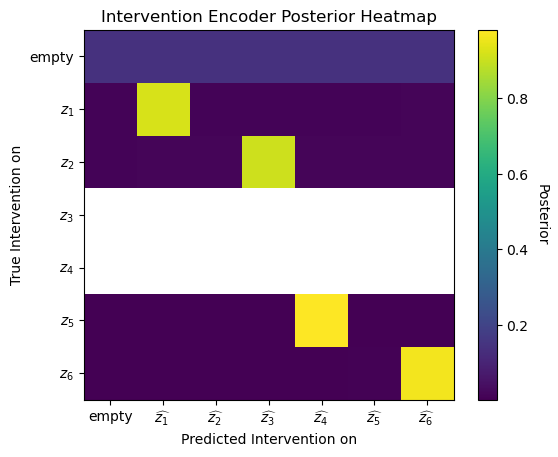

In [108]:
intervention_posteriors, intervention_labels = calculate_intervention_posteriors(
    model, filtered_val_loader, device=device
)
heatmap = calculate_intervention_posterior_heatmap(
    intervention_posteriors, intervention_labels, dim_z, device=device
)
plot_intervention_posterior_heatmap(heatmap, dim_z)

## Disentanglement

In [109]:
def generate_directed_graph_matrix(edge_dict, target_prefix):
    """
    Utility function to generate a directed graph matrix from a dictionary of edges.
    """
    # Get the keys with the target prefix
    keys_with_prefix = [key for key in edge_dict if key.startswith(target_prefix)]

    # Extract the i and j values from the keys
    indices = [
        (int(key[len(target_prefix) :].split("_")[0]), int(key[len(target_prefix) :].split("_")[1]))
        for key in keys_with_prefix
    ]

    # Determine the size of the matrix
    matrix_size = max(max(indices, key=lambda x: max(x))) + 1

    # Initialize an empty tensor and populate it based on the dictionary keys with the target prefix
    graph_tensor = torch.zeros(matrix_size, matrix_size)

    for key in keys_with_prefix:
        i, j = map(int, key[len(target_prefix) :].split("_"))
        graph_tensor[i, j] = edge_dict[key]

    return graph_tensor

In [130]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

from ws_crl.metrics import _compute_disentanglement, _compute_completeness, _verify_inputs


def _train_dci_classifier(
    true_z_train, model_z_train, true_z_test, model_z_test, errors_per_dim=True
):
    """
    Trains a boosted decision tree to predict true factors of variation from model latents, and
    returns importance matrix
    """

    _, dim_z_true = true_z_train.shape
    _, dim_z_model = model_z_test.shape

    importance_matrix = np.zeros(shape=[dim_z_model, dim_z_true])

    if errors_per_dim:
        train_errors = [[] for _ in range(dim_z_true)]
        test_errors = [[] for _ in range(dim_z_true)]
    else:
        # Loop over true factors of variation and train a predictor each
        train_errors, test_errors = [], []
    for i in range(dim_z_true):
        model = GradientBoostingRegressor()
        model.fit(model_z_train, true_z_train[:, i])

        importance_matrix[:, i] = np.abs(model.feature_importances_)
        if not errors_per_dim:
            train_errors.append(
                mean_squared_error(model.predict(model_z_train), true_z_train[:, i])
            )
            test_errors.append(mean_squared_error(model.predict(model_z_test), true_z_test[:, i]))
        else:
            train_errors[i].append(
                mean_squared_error(model.predict(model_z_train), true_z_train[:, i])
            )
            test_errors[i].append(
                mean_squared_error(model.predict(model_z_test), true_z_test[:, i])
            )

    if errors_per_dim:
        train_errors = [np.mean(x) for x in train_errors]
        test_errors = [np.mean(x) for x in test_errors]
    else:
        train_errors = np.mean(train_errors)
        test_errors = np.mean(test_errors)
    return importance_matrix, train_errors, test_errors


def compute_dci(
    true_z_train, model_z_train, true_z_test, model_z_test, return_full_importance_matrix=False
):
    """
    Computes the DCI scores (disentanglement, completeness, informativeness) from a given dataset.

    Based on Eastwood & Williams, ICLR 2018 (https://openreview.net/pdf?id=By-7dz-AZ).

    Parameters:
    -----------
    true_z_train : torch.Tensor, shape (n_samples, n_true_latents)
    model_z_train : torch.Tensor, shape (n_samples, n_true_latents)
    true_z_test : torch.Tensor, shape (n_samples, n_model_latents)
    model_z_test : torch.Tensor, shape (n_samples, n_model_latents)

    Returns:
    --------
    results : dict
    """

    # Check inputs and convert to numpy arrays
    _verify_inputs(true_z_train, model_z_train, true_z_test, model_z_test)
    model_z_test = model_z_test.detach().cpu().data.numpy()
    model_z_train = model_z_train.detach().cpu().data.numpy()
    true_z_test = true_z_test.detach().cpu().data.numpy()
    true_z_train = true_z_train.detach().cpu().data.numpy()

    # Train classifier and compute importance matrix
    importance_matrix, train_err, test_err = _train_dci_classifier(
        true_z_train, model_z_train, true_z_test, model_z_test
    )

    # Extract DCI metrics
    metrics = {
        "informativeness_train": train_err,
        "informativeness_test": test_err,
        "disentanglement": _compute_disentanglement(importance_matrix),
        "completeness": _compute_completeness(importance_matrix),
    }

    # Optionally, also return full importance matrix
    if return_full_importance_matrix:
        for i in range(importance_matrix.shape[0]):
            for j in range(importance_matrix.shape[1]):
                metrics[f"importance_matrix_{i}_{j}"] = importance_matrix[i, j]

    return metrics


@torch.no_grad()
def eval_dci_scores(
    cfg,
    model,
    partition="val",
    test_loader=None,
    dci_train_loader=None,
    full_importance_matrix=True,
    mask_indices_model=None,
    mask_indices_true=None,
    encode_x=True,
):
    """Evaluates DCI scores"""

    model.eval()
    device = torch.device(cfg.training.device)
    cpu = torch.device("cpu")
    model = model.to(device)

    def _load(
        partition,
        device,
        out_device,
        dataloader=None,
        mask_indices_model=None,
        mask_indices_true=None,
    ):
        if dataloader is None:
            dataloader = get_dataloader(
                cfg, partition, cfg.eval.batchsize, include_noise_encodings=True
            )

        model_z, true_z = [], []
        model_e, true_e = [], []

        for x_batch, _, true_z_batch, *_, true_e_batch, _ in dataloader:
            x_batch = x_batch.to(device)

            if encode_x:
                z_batch = model.encode_to_causal(x_batch, deterministic=True)
                e_batch = model.encode_to_noise(x_batch, deterministic=True)
            else:
                # For dummy encoder
                true_z_batch = true_z_batch.to(device)
                true_e_batch = true_e_batch.to(device)
                z_batch, _ = model.encode(true_z_batch)
                e_batch, _ = model.encode(true_e_batch)

            model_z.append(z_batch.to(out_device))
            model_e.append(e_batch.to(out_device))
            true_z.append(true_z_batch.to(out_device))
            true_e.append(true_e_batch.to(out_device))

        model_z = torch.cat(model_z, dim=0).detach()
        true_z = torch.cat(true_z, dim=0).detach()
        model_e = torch.cat(model_e, dim=0).detach()
        true_e = torch.cat(true_e, dim=0).detach()
        if mask_indices_model is not None:
            model_z[:, mask_indices_model] = 0
            model_e[:, mask_indices_model] = 0
        if mask_indices_true is not None:
            true_z[:, mask_indices_true] = 0
            true_e[:, mask_indices_true] = 0

        # return true_z, model_z, true_e, model_e
        return true_z.squeeze(), model_z.squeeze(), true_e.squeeze(), model_e.squeeze()

    # train_true_z, train_model_z, train_true_e, train_model_e = _load("dci_train", device, cpu)
    train_true_z, train_model_z, train_true_e, train_model_e = (
        _load(
            "dci_train",
            device,
            cpu,
            mask_indices_model=mask_indices_model,
            mask_indices_true=mask_indices_true,
        )
        if dci_train_loader is None
        else _load(
            "dci_train",
            device,
            cpu,
            dataloader=dci_train_loader,
            mask_indices_model=mask_indices_model,
            mask_indices_true=mask_indices_true,
        )
    )
    test_true_z, test_model_z, test_true_e, test_model_e = _load(
        partition,
        device,
        cpu,
        dataloader=test_loader,
        mask_indices_model=mask_indices_model,
        mask_indices_true=mask_indices_true,
    )

    causal_dci_metrics = compute_dci(
        train_true_z,
        train_model_z,
        test_true_z,
        test_model_z,
        return_full_importance_matrix=full_importance_matrix,
    )
    noise_dci_metrics = compute_dci(
        train_true_e,
        train_model_e,
        test_true_e,
        test_model_e,
        return_full_importance_matrix=full_importance_matrix,
    )

    combined_metrics = {}
    for key, val in noise_dci_metrics.items():
        combined_metrics[f"noise_{key}"] = val
    for key, val in causal_dci_metrics.items():
        combined_metrics[f"causal_{key}"] = val

    return combined_metrics

In [131]:
from ws_crl.encoder.flow import SONEncoder


son_encoder = SONEncoder(input_features=cfg.data.dim_z, output_features=cfg.data.dim_z)


class DummyModel(torch.nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder

    def encode(self, x, deterministic=True):
        return self.encoder(x, deterministic=deterministic)


dummy_model = DummyModel(son_encoder)
dummy_model.to(device)
eval_dci_scores(
    cfg, dummy_model, test_loader=val_loader, dci_train_loader=train_loader, encode_x=False
)

{'noise_informativeness_train': [0.00012165667183772983,
  9.401784288968646e-05,
  0.00019330587791013275,
  3.298442135126093e-05,
  0.0002269350545809932,
  0.00013545148760854211],
 'noise_informativeness_test': [0.00016697252160025367,
  0.00013324071875449477,
  0.0002724299666705228,
  4.718514169403006e-05,
  0.00031868426030031815,
  0.00019553444390325476],
 'noise_disentanglement': 0.9688704692595556,
 'noise_completeness': 0.9688717889683114,
 'noise_importance_matrix_0_0': 0.9939171538888032,
 'noise_importance_matrix_0_1': 0.0004175695607561623,
 'noise_importance_matrix_0_2': 0.002715572116167519,
 'noise_importance_matrix_0_3': 4.9234876215255446e-05,
 'noise_importance_matrix_0_4': 0.0008983511580445348,
 'noise_importance_matrix_0_5': 0.0029068672851883886,
 'noise_importance_matrix_1_0': 0.0005151361548811938,
 'noise_importance_matrix_1_1': 0.9954515807298601,
 'noise_importance_matrix_1_2': 0.0008082410471945498,
 'noise_importance_matrix_1_3': 0.000189801899842988

In [123]:
eval_dci_scores(
    cfg,
    model,
    test_loader=val_loader,
)

{'noise_informativeness_train': [1.227526265826239e-05,
  1.1222408058031118e-05,
  1.088468976623282e-05,
  1.0730816284228891e-05,
  1.1128821960942853e-05,
  1.1348693364404178e-05],
 'noise_informativeness_test': [1.8899205089955235e-05,
  1.9249290711950357e-05,
  2.143113915950911e-05,
  2.2577118693835018e-05,
  1.976633981586913e-05,
  2.0716975799314353e-05],
 'noise_disentanglement': 0.9999572279083158,
 'noise_completeness': 0.9999572279087043,
 'noise_importance_matrix_0_0': 0.9999954777861159,
 'noise_importance_matrix_0_1': 7.391500419631007e-07,
 'noise_importance_matrix_0_2': 4.2821868399434446e-07,
 'noise_importance_matrix_0_3': 9.789403188258573e-07,
 'noise_importance_matrix_0_4': 1.3672872251609106e-06,
 'noise_importance_matrix_0_5': 1.0983746960599355e-06,
 'noise_importance_matrix_1_0': 1.3064983060543055e-06,
 'noise_importance_matrix_1_1': 0.9999951370008946,
 'noise_importance_matrix_1_2': 1.8687978027751483e-06,
 'noise_importance_matrix_1_3': 5.663664518050

In [122]:
def plot_importance_matrix(importance_matrix, variable_type: str, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    img = ax.imshow(importance_matrix.cpu().detach().numpy())
    ax.set_xticks(range(importance_matrix.shape[0]))
    ax.set_yticks(range(importance_matrix.shape[1]))
    ax.set_xticklabels([f"$z_{i + 1}$" for i in range(importance_matrix.shape[0])])
    ax.set_yticklabels([f"$\widehat{{z{i + 1}}}$" for i in range(importance_matrix.shape[1])])
    ax.set_xlabel("True")
    ax.set_ylabel("Model")
    ax.set_title(f"{variable_type.title()} Importance Matrix")
    cbar = ax.figure.colorbar(img, ax=ax)
    cbar.ax.set_ylabel("Importance", rotation=-90, va="bottom")

Noise importance matrix vs Intervention Posterior Heatmap

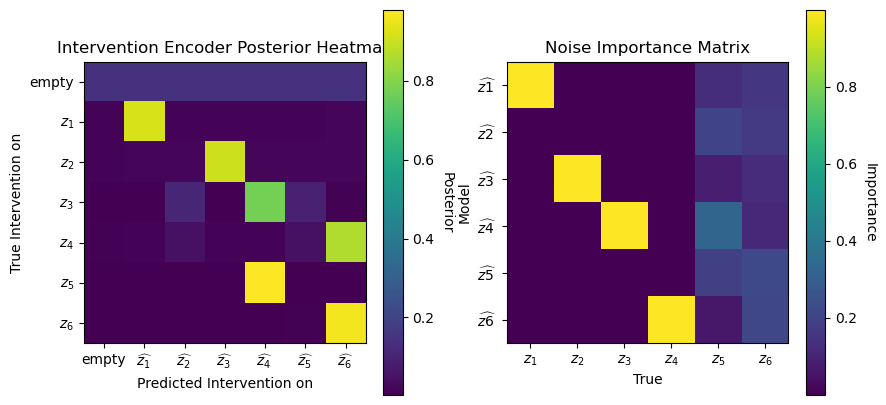

In [112]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
heatmap_val = calculate_intervention_posterior_heatmap(
    intervention_posteriors_val, intervention_labels_val, dim_z, device=device
)
plot_intervention_posterior_heatmap(heatmap_val, dim_z, axes[0])

variable_type = "noise"
outputs = eval_dci_scores(
    cfg,
    model,
    test_loader=val_loader,
)
plot_importance_matrix(
    generate_directed_graph_matrix(outputs, variable_type + "_importance_matrix_"),
    variable_type=variable_type,
    ax=axes[1],
)

Even though, for the validation dataset, the correct intervention is identified, the noise encoding for the child variables are not important for predicting true noise encodings for the child variables.

In [113]:
def plot_errors_per_dim(errors, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.bar(range(len(errors)), errors)
    ax.set_xticks(range(len(errors)))
    ax.set_xticklabels([f"$z_{i + 1}$" for i in range(len(errors))])
    ax.set_xlabel("Latent Dimension")
    ax.set_ylabel("Mean Squared Error")
    ax.set_title("Informativeness")
    plt.show()

In [114]:
def plot_dci(
    cfg, model, val_loader, variable_type="noise", mask_indices_model=None, mask_indices_true=None
):
    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
    outputs = eval_dci_scores(
        cfg,
        model,
        test_loader=val_loader,
        mask_indices_model=mask_indices_model,
        mask_indices_true=mask_indices_true,
    )

    print(f"{variable_type=}")
    print(f"{outputs[variable_type + '_disentanglement']=}")
    print(f"{outputs[variable_type + '_completeness']=}")
    print(
        f"{outputs[variable_type + '_informativeness_train']=}, {outputs[variable_type + '_informativeness_test']=}"
    )
    plot_importance_matrix(
        generate_directed_graph_matrix(outputs, variable_type + "_importance_matrix_"),
        variable_type=variable_type,
        ax=axes[0],
    )
    plot_errors_per_dim(outputs[variable_type + "_informativeness_test"], ax=axes[1])

Plot shows that for the first 4 true noise variables one of the noise encodings suffice (good completeness). However, for the last two (child variable), multiple encodings are used for prediction (bad completeness).
This leads to bad disentanglement because the variables are also used to predict the children variables.

variable_type='noise'
outputs[variable_type + '_disentanglement']=0.6178803324693556
outputs[variable_type + '_completeness']=0.6796183160971481
outputs[variable_type + '_informativeness_train']=[1.9243562655376638e-05, 1.9752935074703536e-05, 0.0007271707903971304, 0.0009460149815059246, 0.20138586777241152, 0.21320797792403767], outputs[variable_type + '_informativeness_test']=[5.283218169196724e-05, 5.648282373850698e-05, 0.0013829817236790313, 0.0016986624473401568, 0.330567194421032, 0.34684117568847306]


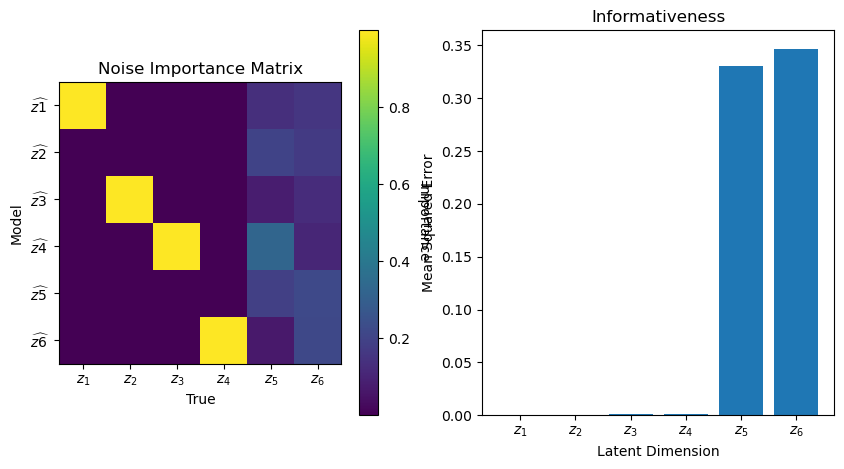

In [115]:
plot_dci(cfg, model, val_loader, variable_type="noise")

We can see that most of the prediction error comes from the child noise components.

### Masking different model/noise dimensions

variable_type='noise'
outputs[variable_type + '_disentanglement']=0.46268838639559506
outputs[variable_type + '_completeness']=0.6916945330358603
outputs[variable_type + '_informativeness_train']=[1.968506071829012e-05, 2.0381636443153357e-05, 0.002218169248520237, 0.0010297159341085213, 0.23794914177493823, 0.23232648506888182], outputs[variable_type + '_informativeness_test']=[5.2955034035482776e-05, 5.6748790400283357e-05, 0.0036623335077377722, 0.0017953139683387703, 0.36226990635325584, 0.345465451869581]


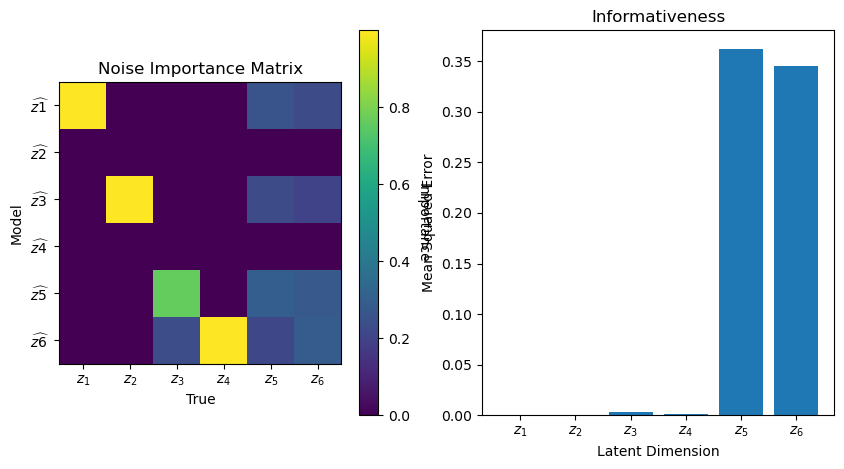

In [116]:
# model: cone object
plot_dci(cfg, model, val_loader, variable_type="noise", mask_indices_model=[1, 3])

variable_type='noise'
outputs[variable_type + '_disentanglement']=0.9987718974136275
outputs[variable_type + '_completeness']=0.9965692113768869
outputs[variable_type + '_informativeness_train']=[1.924356265537664e-05, 1.975293507470356e-05, 0.0007271707903971303, 0.0009460149815059247, 0.0, 0.0], outputs[variable_type + '_informativeness_test']=[5.282317687325601e-05, 5.6492633643668745e-05, 0.0013835720591681552, 0.0016979649256314373, 0.0, 0.0]


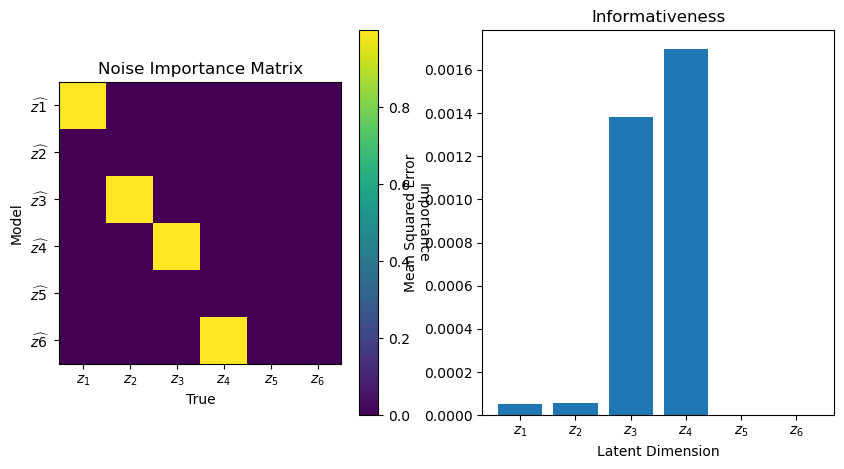

In [117]:
# true: child object
plot_dci(cfg, model, val_loader, variable_type="noise", mask_indices_true=[4, 5])

variable_type='noise'
outputs[variable_type + '_disentanglement']=0.9138668841528045
outputs[variable_type + '_completeness']=0.9217733817569684
outputs[variable_type + '_informativeness_train']=[1.9685060718290163e-05, 2.038163644315337e-05, 0.0022181692485202377, 0.001029715934108521, 0.0, 0.0], outputs[variable_type + '_informativeness_test']=[5.297513428697656e-05, 5.671363444067051e-05, 0.0036517938557979334, 0.0017955791280401781, 0.0, 0.0]


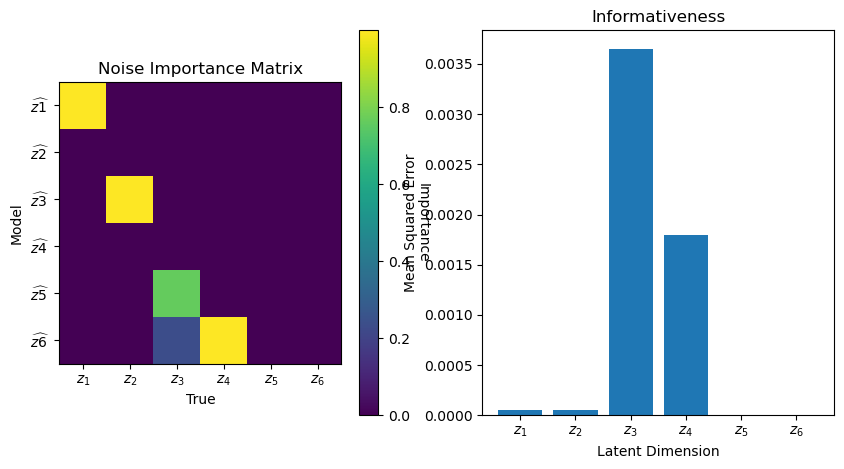

In [118]:
# model: cone object, true: child object
plot_dci(
    cfg,
    model,
    val_loader,
    variable_type="noise",
    mask_indices_model=[1, 3],
    mask_indices_true=[4, 5],
)

variable_type='noise'
outputs[variable_type + '_disentanglement']=0.6176697045650313
outputs[variable_type + '_completeness']=0.6202442827510677
outputs[variable_type + '_informativeness_train']=[0.0, 0.0, 0.0, 0.0, 0.2503203770868988, 0.25735348662698815], outputs[variable_type + '_informativeness_test']=[0.0, 0.0, 0.0, 0.0, 0.35344682632911023, 0.3484975196536024]


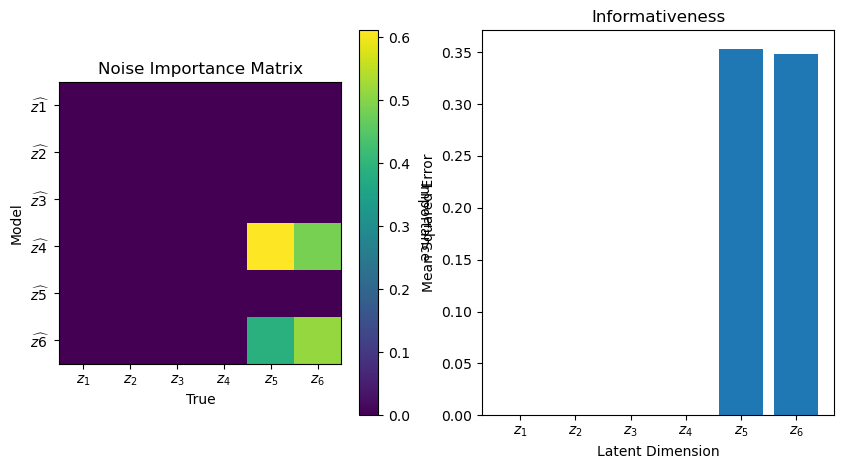

In [119]:
# only keep child object
plot_dci(
    cfg,
    model,
    val_loader,
    variable_type="noise",
    mask_indices_true=[0, 1, 2, 3],
    mask_indices_model=[0, 1, 2, 4],
)

### Causal variables

variable_type='causal'
outputs[variable_type + '_disentanglement']=0.3975621674392128
outputs[variable_type + '_completeness']=0.42543256035728305
outputs[variable_type + '_informativeness_train']=[1.3654314568209065, 1.634284166624555, 3.872639371504992, 3.802006539336667, 0.15757367358958152, 0.27237081405014807], outputs[variable_type + '_informativeness_test']=[2.6720124896009345, 2.859804485169766, 7.326026548715665, 6.804173328803909, 0.31721946854976374, 0.5007099504848097]


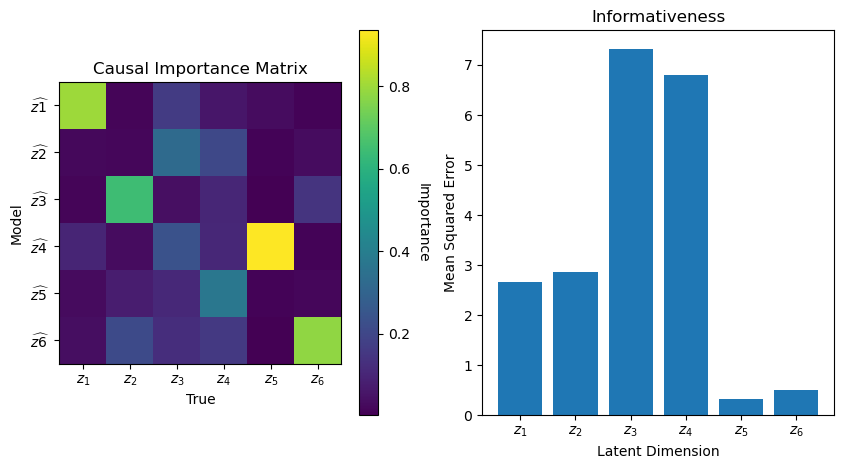

In [120]:
plot_dci(cfg, model, val_loader, variable_type="causal")